# Windy gridworld with $n$-step SARSA

The target for for $n$-step SARSA is

$$
    y(s,a) = \sum_{k=1}^n \gamma^{k-1}\,r_{t+n} + \gamma^n Q(s_{t+n}, a_{t+n}).
$$

The update takes the form
$$
    Q(s, a) = Q(s, a) + \alpha\,[y(s,a) - Q(s,a)]
$$

In [1]:
from tabrl import agents, gridworld

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit
from itertools import product

In [3]:
%config InlineBackend.figure_format = "retina"

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
n_rows = 7
n_cols = 10

In [16]:
movements = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # down,
    [-1, 0], # up
    [0, 0], # nothing
])
n_actions = len(movements)

name_movements = ["right", "left", "down", "up"]
name_movements = ["right", "left", "down", "up", "nothing"]

In [17]:
start_ix = 30
end_ix = 37
reward_goal =  20
G = gridworld.WindyGridworld(start_ix, end_ix, n_rows, n_cols, reward_goal)

## $n$-step SARSA updates

In [108]:
def update_buffer(buffer, new_element):
    """
    Update buffer FIFO mode.
    We assume that elements in the buffer are time-ordered
    along the first axis.

    Parameters
    ----------
    buffer: np.array
        (B, ...)
    new_element: np.array
        (...,)
    """
    buffer = np.copy(buffer)
    buffer = np.roll(buffer, -1, axis=0)
    return buffer


def flush_buffer(buffer):
    """
    Delete all elements in the buffer
    """
    return buffer * np.nan

In [109]:
buffer_size = 10

buffer_rewards = np.zeros(buffer_size) * np.nan
buffer_actions = np.zeros(buffer_size) * np.nan
buffer_states = np.zeros(buffer_size) * np.nan

In [111]:
G.ix_goal

37

In [119]:
Q = np.zeros((G.n_rows * G.n_cols, n_actions)) # action-value function

n_steps = 5000
ix = start_ix
action = agents.choose_action(ix, Q, epsilon)
ix_hist = [ix]
action_hist = [action]
reward_hist = [0]

for t in range(n_steps):
    agents.set_seed(314 + t)

    # 1. take step, obtain reward and new state
    r, ix_new = G.step(ix, action, movements)

    # 2. Select the new action based on Q and the new state
    # epsilon-greedy style
    action_new = agents.choose_action(ix_new, Q, epsilon)

    # 3. Update buffers:
    # insert newest (state/action/reward) and remove oldest (state/action/reward)
    buffer_states = update_buffer(buffer_states, ix_new)
    buffer_actions = update_buffer(buffer_actions, action_new)
    buffer_rewards = update_buffer(buffer_rewards, r)

    # 3.1. Upate elements
    ix, action = ix_new, action_new

    action_hist.append(action)
    ix_hist.append(ix)
    reward_hist.append(r)


    # 3.1 Continue interacting with the environment without updates until
    # the buffer is full or we reach an end state
    is_buffer_full = not np.isnan(buffer_rewards).any()
    end_goal_reached = (ix == G.ix_goal)
    if not (is_buffer_full and end_goal_reached):
        continue

    # 3. Select new action based on buffer rewards,
    # last action taken and last encountered state
    Q = agents.nstep_sarsa_update(buffer_states, buffer_actions, buffer_rewards, Q, alpha, gamma, end_goal_reached)

action_hist = np.array(action_hist)
ix_hist = np.array(ix_hist)
reward_hist = np.array(reward_hist)

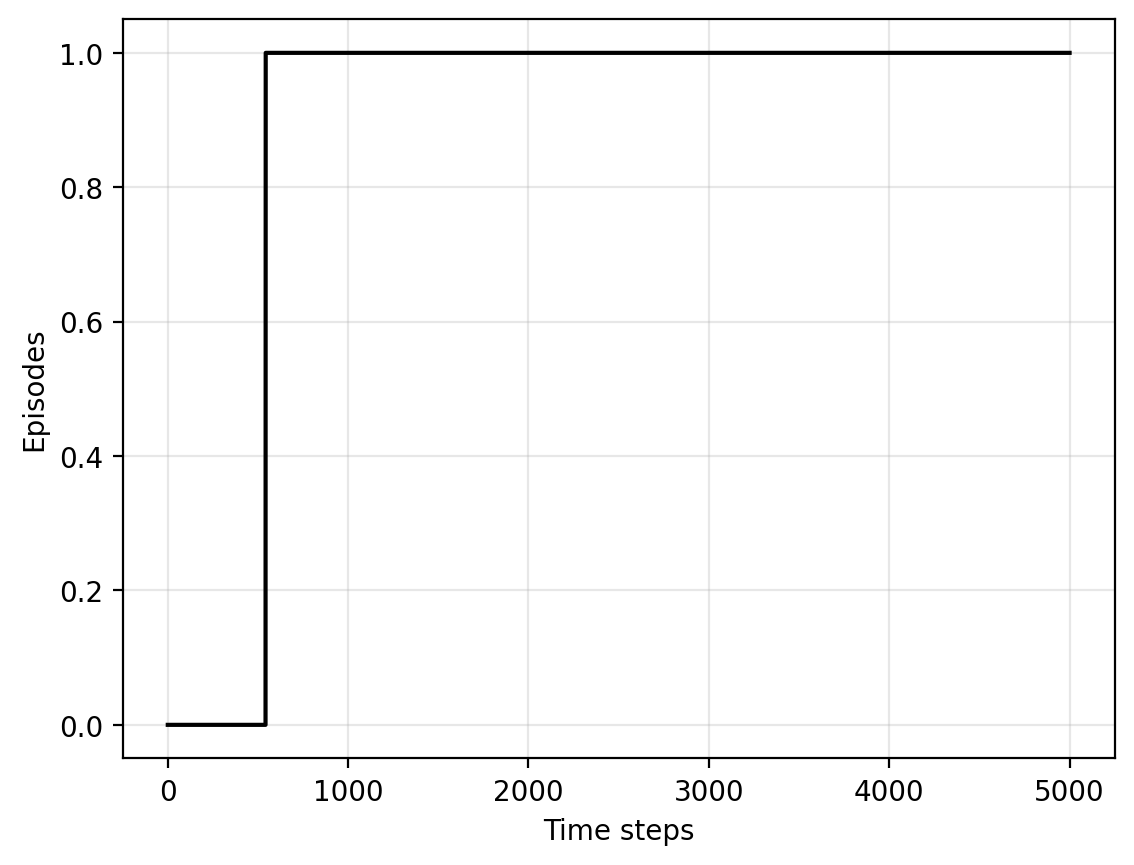

In [121]:
plt.plot((reward_hist == reward_goal).cumsum(), c="black")
plt.grid(alpha=0.3)
plt.xlabel("Time steps")
plt.ylabel("Episodes");

## SARSA updates

In [88]:
%%time
Q = np.zeros((G.n_rows * G.n_cols, n_actions)) # action-value function

epsilon = 0.01
alpha = 0.5
gamma = 1.0

agents.set_seed(314-1)
ix = start_ix
action = agents.choose_action(ix, Q, epsilon)
ix_hist = [ix]
action_hist = [action]
reward_hist = [0]

for i in range(5_000):
    agents.set_seed(314 + i)

    # 1. take step, obtain reward and new state
    r, ix_new = G.step(ix, action, movements)
    
    # 2. Choose 'a_new' based on Q and 's_new'
    action_new = agents.choose_action(ix_new, Q, epsilon)

    # 3. Update agent based on state, new-state, action taken, and reward
    Q = agents.sarsa_update(ix, action, r, ix_new, action_new, Q, alpha, gamma, epsilon)

    ix, action = ix_new, action_new

    action_hist.append(action)
    ix_hist.append(ix)
    reward_hist.append(r)

action_hist = np.array(action_hist)
ix_hist = np.array(ix_hist)
reward_hist = np.array(reward_hist)

CPU times: user 21.8 ms, sys: 391 μs, total: 22.2 ms
Wall time: 22 ms


In [89]:
reward_hist[-500:].mean()

np.float64(0.302)

In [90]:
ix_goal = np.where(reward_hist == reward_goal)[0]
pos_hist = np.c_[ix_hist % n_cols, ix_hist // n_cols]
distance_hist = np.abs(pos_hist - G.get_pos(end_ix)).sum(axis=1)
len(ix_goal)

84

In [91]:
markers = {
    "down": "v",
    "up": "^",
    "right": ">",
    "left": "<",
    "nothing": "o"
}

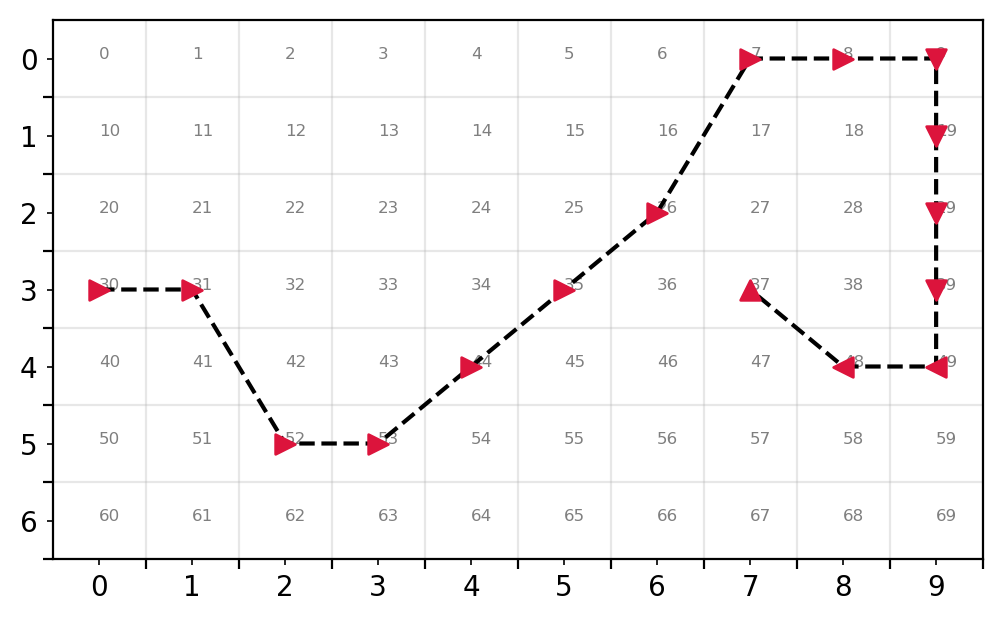

In [92]:
run = -2
iinit = ix_goal[run]
iend = ix_goal[run + 1]

subhist_action = action_hist[iinit:iend]
subhist_action = [name_movements[a] for a in subhist_action]
subhist_action = [markers[action] for action in subhist_action]

subhist_pos = pos_hist[iinit:iend]

fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.5))
plt.plot(*subhist_pos.T, c="black", linestyle="--")

for (x,y), m in zip(subhist_pos, subhist_action):
    plt.scatter(x, y, marker=m, zorder=3, s=50, c="crimson")

xticks = np.arange(n_cols)
yticks = np.arange(n_rows)
ax.set(
    xticks=xticks + 0.5,
    yticks=yticks + 0.5,
    xticklabels="",
    yticklabels="",
)
ax.set_xticks(xticks, labels=xticks, minor=True)
ax.set_yticks(yticks, labels=yticks, minor=True)

# ax.scatter(*pos_hist[iinit], marker="$S$", s=100, zorder=3)
# ax.scatter(*pos_hist[iend-1], marker="$G$", s =100, c="crimson", zorder=3)
ax.set_ylim(-0.5, n_rows - 0.5)
ax.set_xlim(-0.5, n_cols - 0.5)
ax.invert_yaxis()


for i, (r, c) in enumerate(product(range(G.n_rows), range(G.n_cols))):
    plt.text(c, r, i, c="tab:gray", zorder=0, fontsize=6)

plt.grid(alpha=0.3)
# plt.savefig("windy-gridworld.png", bbox_inches="tight", dpi=150)

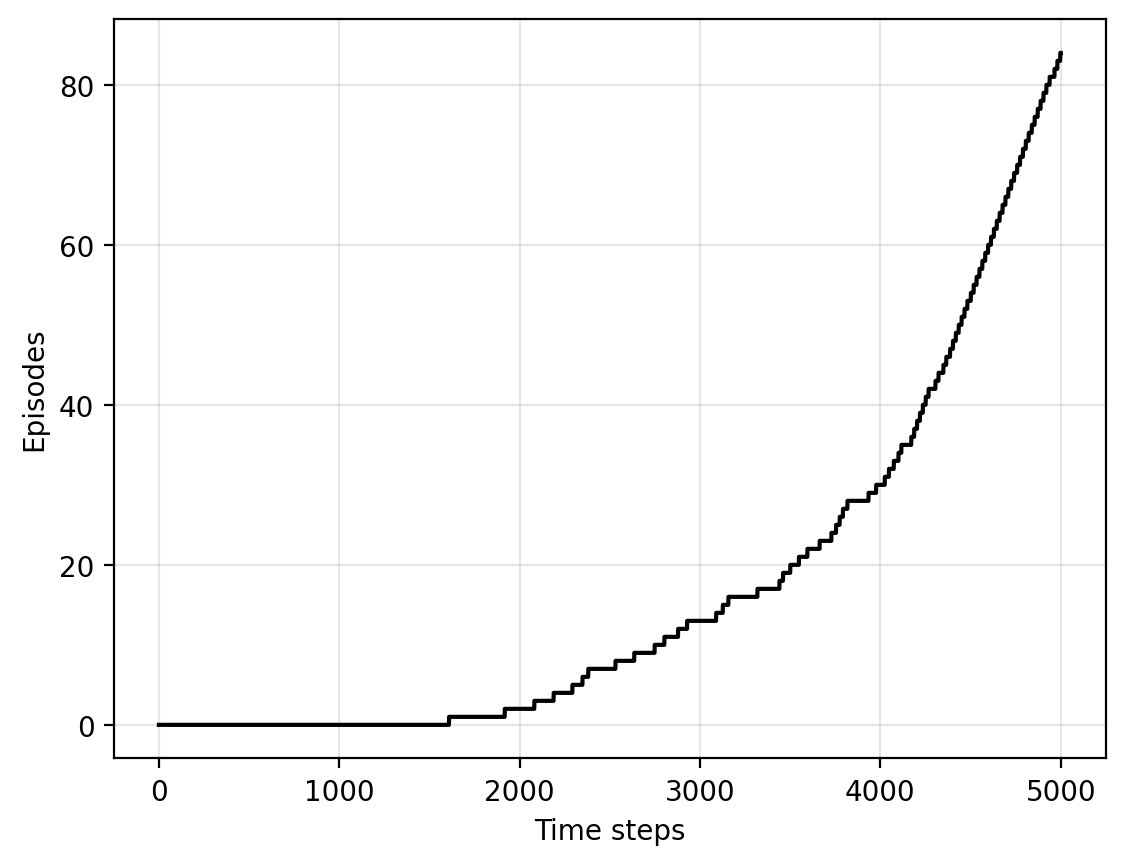

In [93]:
plt.plot((reward_hist == reward_goal).cumsum(), c="black")
plt.grid(alpha=0.3)
plt.xlabel("Time steps")
plt.ylabel("Episodes");